# IMDb Web Scraping and Analysis with Selenium Python 

### Authors

- Sophia Tsilerides, smt570 (responsible for submissions)
- Ilana Weinstein, igw212
- Amanda Kuznecov, anr431

### Abstract

This project focuses on the elements that comprise a critically acclaimed film as defined by IMDb’s Top 250 Movie list. We approach this problem using web scraping and web-based automation tools in Python. Our results show that this is an effective and efficient way to collect data which visualizations can be made from to draw conclusions.

### Background
In order to put tools from class into practice, we have gathered data from the IMDb website to analyze and observe trends in the movie industry, with the goal of creating meaningful visualizations. We chose to use data from IMDb, an online database containing information about movies, because we share a common interest in movies and were excited to work with the information in this dataset. A great deal of information about movies is presented on IMDb’s website, however, it is not presented in a way where meaningful insights can be visualized.
 
The Top 250 Movie list on IMDb’s website was specifically chosen for further analysis as it was very well structured. Website scraping was automated for efficiency and reusability using Selenium. To maximize value, we merged the IMDb dataset with another dataset containing biographical information of actors. Upon scraping IMDb and merging with the other dataset, data cleaning and inspection were required before continuing any work. By creating an aggregated dataset, we were able to analyze correlations between movie genres, ratings, revenue, actor age and gender. 

Our data sources are:
- “IMDb ‘Top 250.’” IMDb, IMDb.com, www.imdb.com/search/title/?groups=top_250&amp;sort=user_rating
- DeathReaper0965. “DeathReaper0965/Movie_ratings_prediction.” GitHub, github.com/DeathReaper0965/Movie_ratings_prediction.

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import pandas as pd
from selenium import webdriver

### Part I: Web Scraping Tool & Selenium
Creating a function that web scrapes from current page (using selenium), parses the HTML, and stores in a pandas DataFrame.

In [2]:
def web_scrape_page():
    
    url = driver.current_url
    resp = requests.get(url)
    
    #All info from current driver.page_source scraped
    soup = BeautifulSoup(resp.text,'html.parser')
    
    #Scraping header: movie title and year
    scraped_titles = soup.find_all('h3',{"class":"lister-item-header"})
    
    #Scraping for movie title
    movies = []
    for x in scraped_titles:
        for y in x.find_all('a'):
            movies.append(y.text)
    
    #Scraping for movie year
    years = []
    for x in scraped_titles:
        for y in x.find_all('span'):
            years.append(y.text)
    years = years[1::2]
    
    #Scraping from muted text, which is where the movie details are stored: rating, time, genres
    scraped_details = soup.find_all('p',{"class":"text-muted"})
    details = []
    for x in scraped_details:
        for y in x.find_all('span'):
            details.append(y.text)
    
    #Scraping rating, length of film and genres
    rating_types = np.unique(details[0::5])
    correct_rating_types = []

    for i in range(0,len(rating_types)):
        if 'min' not in rating_types[i]:
            correct_rating_types.append(rating_types[i])
    
    ratings = []
    time = []
    genres = []

    for i in range(0,len(details),5):
        if details[i] in correct_rating_types:
            ratings.append(details[i])
            time.append(details[i+2].strip(' min'))
            genres.append(details[i+4].strip())
        else:
            if details[i-2] == '|':
                ratings.append('Not Rated')
            else:
                ratings.append(details[i-2])
            time.append(details[i].strip(' min'))
            genres.append(details[i+2].strip())

    
    #Scraping from ratings bar
    scraped_ratings_bar = soup.find_all('div',{"class":"ratings-bar"})
    s = []
    for x in scraped_ratings_bar:
        for y in x.find_all('div',{"class":"inline-block ratings-imdb-rating"}):
            s.append(y.text)
    stars = []
    for i in s:
        stars.append(i.strip("\n"))
        
    #Scraping directors 
    directors = []
    for element in soup.find_all(text=re.compile("Director")):
        a = element.nextSibling
        directors.append(a.text)
    
    #Scraping actors
    actors = []
    for element in soup.find_all(text=re.compile("Stars")):
        a = element.nextSibling
        if a is None:
            actors.append('None')
        else:
            actors.append(a.string)
        
    #Scraping from num votes, which is where votes and gross $ are stored
    scraped_nums = soup.find_all('p',{"class":"sort-num_votes-visible"})
    nums = []
    for x in scraped_nums:
        for y in x.find_all('span'):
            nums.append(y.text)
    nums = np.array(nums)
    m = []
    for x in scraped_ratings_bar:
        for y in x.find_all('div',{"class":"inline-block ratings-metascore"}):
            m.append(y.text)
    metascore = []

    for i in range(len(m)):
        metascore.append(int(((((((m[i].strip("\n")).strip(" ")).strip("\n")).strip("Metascore")).strip(" ")).strip("\n")).strip(" ")))
    searchval = "Votes:"
    ind = np.where(nums == searchval)[0]+1
    votes = nums[ind]
    searchval = "Gross:"
    ind = np.where(nums == searchval)[0]+1
    gr = nums[ind]
    gross = []

    for i in range(len(gr)):
        a = gr[i].strip("$")
        gross.append(a.strip("M"))
        
    #Creating DataFrame
    df = pd.DataFrame([movies,years,ratings,time,genres,stars,metascore,votes,gross,directors,actors]).transpose()
    df.columns = ['Movie', 'Year', 'Rating', 'Duration (min)', 'Genres','Stars','Metascore','Votes','Gross ($M)', 'Director','Lead']
    
    return df

The movies are spread across 5 different webpages. We use our function to scrape each page and concatenate the resulting DataFrames, reindexing the final DataFrame so each movie has it's unique identifier. 

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
from selenium.common.exceptions import NoSuchElementException
import time

In [5]:
#Initializing pg DataFrame that will eventually contain all scraped information
pg = pd.DataFrame()

#Using selenium's webdriver to create basic Chrome Options when opening browser
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument("--test-type")

#Using selenium's webdriver to open Google Chrome with stated options 
#Goes directly to url which is the first page of IMDB Top 250 list  
driver = webdriver.Chrome(options=options)
driver.get("https://www.imdb.com/search/title/?groups=top_250&sort=user_rating")

#Scrape page until there isn't a 'Next »' button
#Merge previous pages (pg) to current page (pg_current) until no pages are remaining
pages_remaining = True

while pages_remaining == True:

    pg_current = web_scrape_page()
    pg = pd.concat([pg,pg_current])

    try:
        next_link = driver.find_element_by_xpath('//a[contains(.,"Next »")]')
        next_link.click()
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(30)

    except NoSuchElementException:
        pages_remaining = False

#Close browser
driver.close()

In [6]:
movies = pg.reset_index(drop=True)
movies.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead
0,The Shawshank Redemption,(1994),R,142,Drama,9.3,80,"2,166,845",28.34,Frank Darabont,Tim Robbins
1,The Godfather,(1972),R,175,"Crime, Drama",9.2,100,"1,487,833",134.97,Francis Ford Coppola,Marlon Brando
2,The Dark Knight,(2008),PG-13,152,"Action, Crime, Drama",9.0,84,"2,141,781",534.86,Christopher Nolan,Christian Bale
3,The Godfather: Part II,(1974),R,202,"Crime, Drama",9.0,90,"1,036,258",57.30,Francis Ford Coppola,Al Pacino
4,The Lord of the Rings: The Return of the King,(2003),PG-13,201,"Adventure, Drama, Fantasy",8.9,94,"1,538,412",377.85,Peter Jackson,Elijah Wood


### Part II: Data Cleaning

We would like Year to be an integer so we could easily bin for different decades in our visualization. We strip away the paranthesis from the Year series and replace it in the movies DataFrame. 

In [7]:
movies['Year'] = movies['Year'].str.replace('(','')
movies['Year'] = movies['Year'].str.replace(')','')

In [8]:
movies.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead
0,The Shawshank Redemption,1994,R,142,Drama,9.3,80,"2,166,845",28.34,Frank Darabont,Tim Robbins
1,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,487,833",134.97,Francis Ford Coppola,Marlon Brando
2,The Dark Knight,2008,PG-13,152,"Action, Crime, Drama",9.0,84,"2,141,781",534.86,Christopher Nolan,Christian Bale
3,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,036,258",57.30,Francis Ford Coppola,Al Pacino
4,The Lord of the Rings: The Return of the King,2003,PG-13,201,"Adventure, Drama, Fantasy",8.9,94,"1,538,412",377.85,Peter Jackson,Elijah Wood


Some of the data is not clean. There are 5 movies in which the movie name was included in the Year scraping. These 5 instances have to be dealt with individually before we can convert the whole Year column in the movies DataFrame to integers. 

In [9]:
#Example
movies[movies['Movie']== 'Coco']

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead
61,Coco,I 2017,PG,105,"Animation, Adventure, Family",8.4,67,"309,320",448.14,Lee Unkrich,Anthony Gonzalez


In [10]:
#All instances of dirty Year Data
movies['Year'][movies['Year'].str.startswith('I')]

61     I 2017
126    I 2015
174    I 2015
181    I 2013
182    I 2015
Name: Year, dtype: object

In [11]:
movies['Year'] = movies['Year'].str.replace('I','')

In [12]:
movies['Year'] = pd.to_numeric(movies['Year'])              

Now, all the Year data is clean and converted to integers. Below is an example.

In [13]:
movies.loc[124]

Movie                           Green Book
Year                                  2018
Rating                               PG-13
Duration (min)                         130
Genres            Biography, Comedy, Drama
Stars                                  8.2
Metascore                               94
Votes                              265,984
Gross ($M)                            6.39
Director                    Peter Farrelly
Lead                       Viggo Mortensen
Name: 124, dtype: object

In [14]:
movies['Rating'] = movies['Rating'].str.replace('|','Not Rated')

In [15]:
movies

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead
0,The Shawshank Redemption,1994,R,142,Drama,9.3,80,"2,166,845",28.34,Frank Darabont,Tim Robbins
1,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,487,833",134.97,Francis Ford Coppola,Marlon Brando
2,The Dark Knight,2008,PG-13,152,"Action, Crime, Drama",9.0,84,"2,141,781",534.86,Christopher Nolan,Christian Bale
3,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,036,258",57.30,Francis Ford Coppola,Al Pacino
4,The Lord of the Rings: The Return of the King,2003,PG-13,201,"Adventure, Drama, Fantasy",8.9,94,"1,538,412",377.85,Peter Jackson,Elijah Wood
5,Pulp Fiction,1994,R,154,"Crime, Drama",8.9,94,"1,701,298",107.93,Quentin Tarantino,John Travolta
6,Schindler's List,1993,R,195,"Biography, Drama, History",8.9,94,"1,124,404",96.90,Steven Spielberg,Liam Neeson
7,12 Angry Men,1957,Not Rated,96,Drama,8.9,96,"620,457",4.36,Sidney Lumet,Henry Fonda
8,Inception,2010,PG-13,148,"Action, Adventure, Sci-Fi",8.8,74,"1,899,373",292.58,Christopher Nolan,Leonardo DiCaprio
9,Fight Club,1999,R,139,Drama,8.8,66,"1,731,184",37.03,David Fincher,Brad Pitt


### Part III: Merging WebScraped Data with Actor Information Data

To complete the dataset, the web scraped data from IMDb was merged with an actor information dataset provided by https://github.com/DeathReaper0965/Movie_ratings_prediction.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.25)

import os
directory = os.getcwd()

In [17]:
actors = pd.read_csv(directory + '/actors_mod0.csv', sep=',')

In [18]:
#test
actors[actors['stage-name'].str.contains('Marlon Brando')]

,stage-name,dow,bname,gname,gender,dob,dod,role type,picture pointer,notes,award,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
698,Marlon Brando,1950-1980,Brando,Marlon,M,1924,199x,R:modern male,Am,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
new_actors = actors.drop(['Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], 1)

new_actors = new_actors.drop(['dow', 'bname', 'gname','dod','picture pointer', 'notes', 'award'],1)

In [20]:
new_actors.columns

Index(['stage-name', 'gender', 'dob', 'role type'], dtype='object')

In [21]:
new_actors = new_actors.rename(columns={'stage-name': "Lead", 'gender': 'Gender', 'dob':"DOB", 'role type':'Role Type'})
new_actors.head()

,Lead,Gender,DOB,Role Type
0,Willie Aames,M,1960,RU:
1,Bud Abbott,M,1895,R:straight
2,Diahnne Abbott,F,[1][23],R:sexy
3,George Abbott,M,1887,R:playwright
4,John Abbott,M,1905,R:staring eyes


In [53]:
df_merged = pd.merge(movies, new_actors, how='inner', on= 'Lead')

In [54]:
df_merged.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type
0,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,487,833",134.97,Francis Ford Coppola,Marlon Brando,M,1924,R:modern male
1,On the Waterfront,1954,Not Rated,108,"Crime, Drama, Thriller",8.1,97,"132,155",4.36,Elia Kazan,Marlon Brando,M,1924,R:modern male
2,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,036,258",57.30,Francis Ford Coppola,Al Pacino,M,1939,R:malevolent lead
3,Scarface,1983,R,170,"Crime, Drama",8.3,58,"684,993",309.13,Brian De Palma,Al Pacino,M,1939,R:malevolent lead
4,Heat,1995,R,170,"Crime, Drama, Thriller",8.2,96,"537,693",83.01,Michael Mann,Al Pacino,M,1939,R:malevolent lead



Transforming DOB column to contain all valid years, and creating a column to represent actors age at the time the movie was released.

In [57]:
#possible to make this process automated?
a = df_merged['DOB'].str.startswith('1')
b = pd.DataFrame(a)

Fixing errors in the data.

In [58]:
df_merged['Lead'][b['DOB']== False]

9        Liam Neeson
27    Morgan Freeman
54        Jim Carrey
55        Jim Carrey
61    Matthew Modine
76        Bruno Ganz
96     Charlie Sheen
Name: Lead, dtype: object

In [59]:
df_merged.loc[9,'DOB'] = '1952'
df_merged.loc[27,'DOB'] = '1937'
df_merged.loc[54,'DOB'] = '1962'
df_merged.loc[55,'DOB'] = '1962'
df_merged.loc[61,'DOB'] = '1959'
df_merged.loc[76,'DOB'] = '1941'
df_merged.loc[96,'DOB'] = '1965'

In [60]:
df_merged['DOB'] = df_merged['DOB'].astype(float)
df_merged['Age'] = df_merged['Year'] - df_merged['DOB']
df_merged.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age
0,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,487,833",134.97,Francis Ford Coppola,Marlon Brando,M,1924.0,R:modern male,48.0
1,On the Waterfront,1954,Not Rated,108,"Crime, Drama, Thriller",8.1,97,"132,155",4.36,Elia Kazan,Marlon Brando,M,1924.0,R:modern male,30.0
2,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,036,258",57.30,Francis Ford Coppola,Al Pacino,M,1939.0,R:malevolent lead,35.0
3,Scarface,1983,R,170,"Crime, Drama",8.3,58,"684,993",309.13,Brian De Palma,Al Pacino,M,1939.0,R:malevolent lead,44.0
4,Heat,1995,R,170,"Crime, Drama, Thriller",8.2,96,"537,693",83.01,Michael Mann,Al Pacino,M,1939.0,R:malevolent lead,56.0


In [62]:
#check
df_merged['Gender'].unique()

array(['M', 'F'], dtype=object)

Dealing with genres: split on comma and fill `None` where necessary.

In [67]:
glist = df_merged.Genres.str.split(',').tolist()
glist

[['Crime', ' Drama'],
 ['Crime', ' Drama', ' Thriller'],
 ['Crime', ' Drama'],
 ['Crime', ' Drama'],
 ['Crime', ' Drama', ' Thriller'],
 ['Adventure', ' Drama', ' Fantasy'],
 ['Adventure', ' Drama', ' Fantasy'],
 ['Adventure', ' Drama', ' Fantasy'],
 ['Crime', ' Drama'],
 ['Biography', ' Drama', ' History'],
 ['Drama'],
 ['Western'],
 ['Drama', ' Romance'],
 ['Drama', ' War'],
 ['Crime', ' Drama', ' Fantasy'],
 ['Animation', ' Adventure', ' Comedy'],
 ['Animation', ' Adventure', ' Comedy'],
 ['Western'],
 ['Western'],
 ['Drama', ' Western'],
 ['Drama'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Drama'],
 ['Drama', ' Horror'],
 ['Drama', ' Mystery', ' Thriller'],
 ['Crime', ' Drama', ' Mystery'],
 ['Crime', ' Drama', ' Thriller'],
 ['Drama', ' Family', ' Fantasy'],
 ['Mystery', ' Thriller'],
 ['Mystery', ' Romance', ' Thriller'],
 ['Comedy', ' Drama'],
 ['Animation', ' Adventure', ' Drama'],
 ['Action', ' Sci-

In [68]:
maxLen = max(map(len, glist))
max_len = max(len(item) for item in glist)

for item in glist:                # for each item in the list
    while len(item) < max_len:   # while the item length is smaller than 3
        item.append(None)  

In [69]:
genres = pd.DataFrame(glist, columns=['Genre 1','Genre 2', 'Genre 3'])

In [70]:
final_movies = pd.concat([df_merged, genres], axis=1, sort=False)
final_movies.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age,Genre 1,Genre 2,Genre 3
0,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,487,833",134.97,Francis Ford Coppola,Marlon Brando,M,1924.0,R:modern male,48.0,Crime,Drama,None
1,On the Waterfront,1954,Not Rated,108,"Crime, Drama, Thriller",8.1,97,"132,155",4.36,Elia Kazan,Marlon Brando,M,1924.0,R:modern male,30.0,Crime,Drama,Thriller
2,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,036,258",57.30,Francis Ford Coppola,Al Pacino,M,1939.0,R:malevolent lead,35.0,Crime,Drama,None
3,Scarface,1983,R,170,"Crime, Drama",8.3,58,"684,993",309.13,Brian De Palma,Al Pacino,M,1939.0,R:malevolent lead,44.0,Crime,Drama,None
4,Heat,1995,R,170,"Crime, Drama, Thriller",8.2,96,"537,693",83.01,Michael Mann,Al Pacino,M,1939.0,R:malevolent lead,56.0,Crime,Drama,Thriller


Lastly, removing the "R:" from Role Type. 

In [71]:
a = final_movies['Role Type'].str.split('R:')
roles = []
for i in range(len(a)):
    roles.append(a[i][-1])

In [72]:
final_movies['Role Type'] = roles

In [73]:
final_movies.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age,Genre 1,Genre 2,Genre 3
0,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,487,833",134.97,Francis Ford Coppola,Marlon Brando,M,1924.0,modern male,48.0,Crime,Drama,None
1,On the Waterfront,1954,Not Rated,108,"Crime, Drama, Thriller",8.1,97,"132,155",4.36,Elia Kazan,Marlon Brando,M,1924.0,modern male,30.0,Crime,Drama,Thriller
2,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,036,258",57.30,Francis Ford Coppola,Al Pacino,M,1939.0,malevolent lead,35.0,Crime,Drama,None
3,Scarface,1983,R,170,"Crime, Drama",8.3,58,"684,993",309.13,Brian De Palma,Al Pacino,M,1939.0,malevolent lead,44.0,Crime,Drama,None
4,Heat,1995,R,170,"Crime, Drama, Thriller",8.2,96,"537,693",83.01,Michael Mann,Al Pacino,M,1939.0,malevolent lead,56.0,Crime,Drama,Thriller


Checking and converting all columns in the DataFrame.

In [74]:
final_movies["Year"] = final_movies["Year"].astype(int)

In [76]:
final_movies["Duration (min)"] = final_movies["Duration (min)"].astype(int)

In [77]:
final_movies["Stars"] = final_movies["Stars"].astype(float)

In [79]:
final_movies['Metascore'][final_movies["Metascore"].isna()] = 0

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
final_movies["Metascore"] = final_movies["Metascore"].astype(float)

In [83]:
final_movies['Votes'] = final_movies['Votes'].str.replace(',','')

In [84]:
final_movies["Votes"] = final_movies["Votes"].astype(int)

In [85]:
final_movies['Gross ($M)'] = final_movies['Gross ($M)'].fillna(0)
final_movies['Gross ($M)'] = final_movies['Gross ($M)'].astype(float)

Fixing missing values in the data.

In [86]:
final_movies[final_movies['DOB'].isna()]

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age,Genre 1,Genre 2,Genre 3
79,Monty Python and the Holy Grail,1975,PG,91,"Adventure, Comedy, Fantasy",8.2,92.0,473453,1.23,Terry Gilliam,Graham Chapman,M,NaN,character,NaN,Adventure,Comedy,Fantasy
80,Monty Python's Life of Brian,1979,R,94,Comedy,8.1,70.0,343727,48.98,Terry Jones,Graham Chapman,M,NaN,character,NaN,Comedy,None,None
94,Fargo,1996,R,98,"Crime, Drama, Thriller",8.1,85.0,576120,24.61,Joel Coen,William H. Macy,M,NaN,character,NaN,Crime,Drama,Thriller


In [87]:
final_movies.loc[79, 'DOB'] = 1941
final_movies.loc[80, 'DOB'] = 1941
final_movies.loc[94, 'DOB'] = 1950

final_movies.loc[79, 'Age'] = 34
final_movies.loc[80, 'Age'] = 38
final_movies.loc[94, 'Age'] = 46

In [88]:
final_movies["DOB"] = final_movies["DOB"].astype(int)
final_movies['Age'] = final_movies['Age'].astype(int)

In [89]:
final_movies.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age,Genre 1,Genre 2,Genre 3
0,The Godfather,1972,R,175,"Crime, Drama",9.2,100.0,1487833,134.97,Francis Ford Coppola,Marlon Brando,M,1924,modern male,48,Crime,Drama,None
1,On the Waterfront,1954,Not Rated,108,"Crime, Drama, Thriller",8.1,97.0,132155,4.36,Elia Kazan,Marlon Brando,M,1924,modern male,30,Crime,Drama,Thriller
2,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90.0,1036258,57.30,Francis Ford Coppola,Al Pacino,M,1939,malevolent lead,35,Crime,Drama,None
3,Scarface,1983,R,170,"Crime, Drama",8.3,58.0,684993,309.13,Brian De Palma,Al Pacino,M,1939,malevolent lead,44,Crime,Drama,None
4,Heat,1995,R,170,"Crime, Drama, Thriller",8.2,96.0,537693,83.01,Michael Mann,Al Pacino,M,1939,malevolent lead,56,Crime,Drama,Thriller


### Part IV: Visualizations

In order to understand our results, we developed a number of visualizations. 

Text(0.5, 1.0, 'Movie Count by Year')

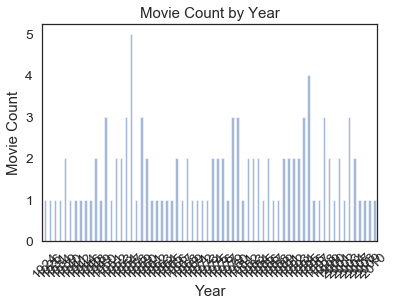

In [90]:
#Determine the amount of movies that were produced each year
movie_yearly_count = final_movies['Year'].value_counts().sort_index().plot(kind='bar', color='b', alpha=0.5, grid=False, rot=45)
movie_yearly_count.set_xlabel('Year')
movie_yearly_count.set_ylabel('Movie Count')
movie_yearly_count.set_title('Movie Count by Year')

In [91]:
movie_yearly_count = final_movies['Year'].value_counts().sort_index()
movie_yearly_count = movie_yearly_count.groupby((movie_yearly_count.index//10)*10).sum()

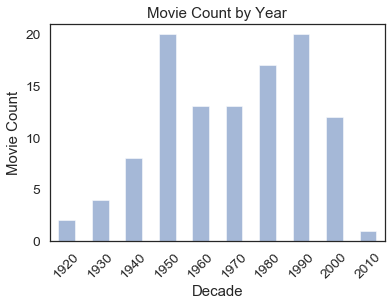

In [92]:
#Determine the amount of movies that were produced each year
new = movie_yearly_count.plot(kind='bar', color='b', alpha=0.5, grid=False, rot=45)
new.set_xlabel('Decade')
new.set_ylabel('Movie Count')
new.set_title('Movie Count by Year');

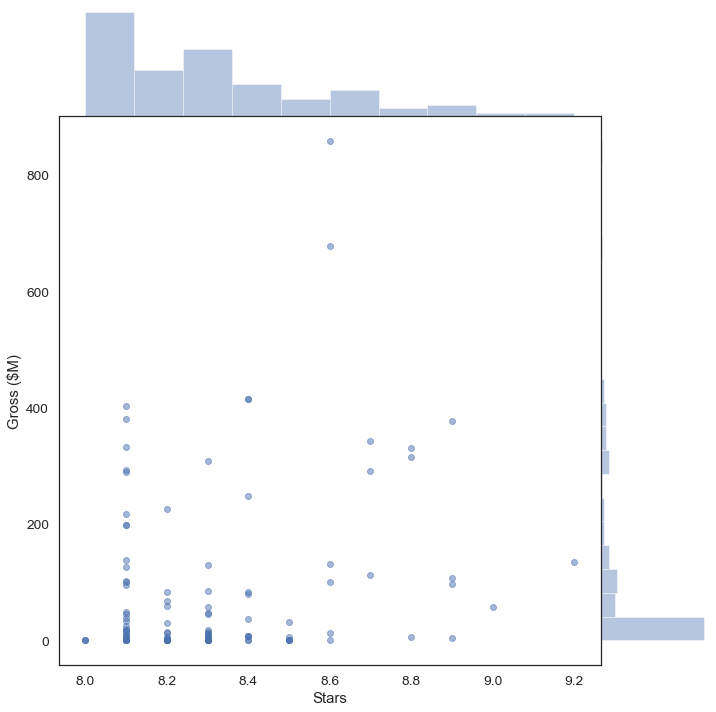

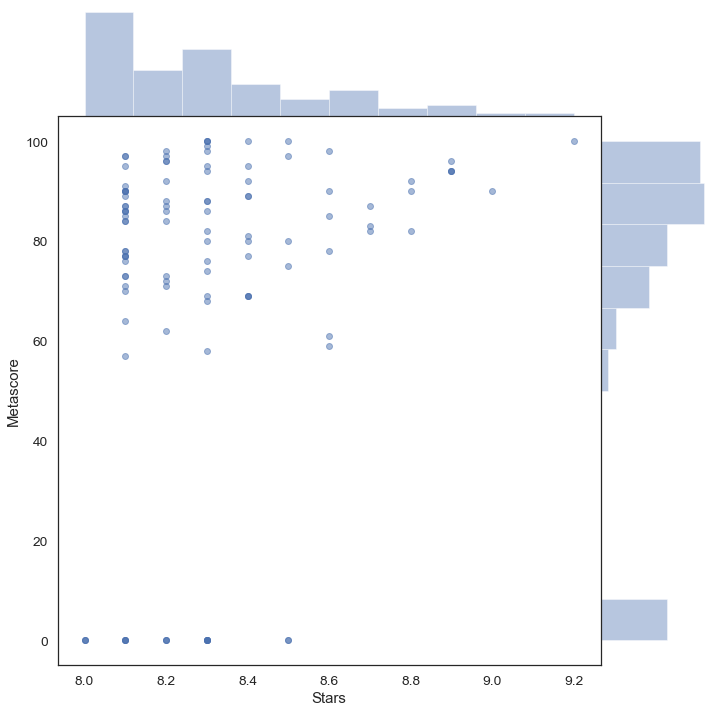

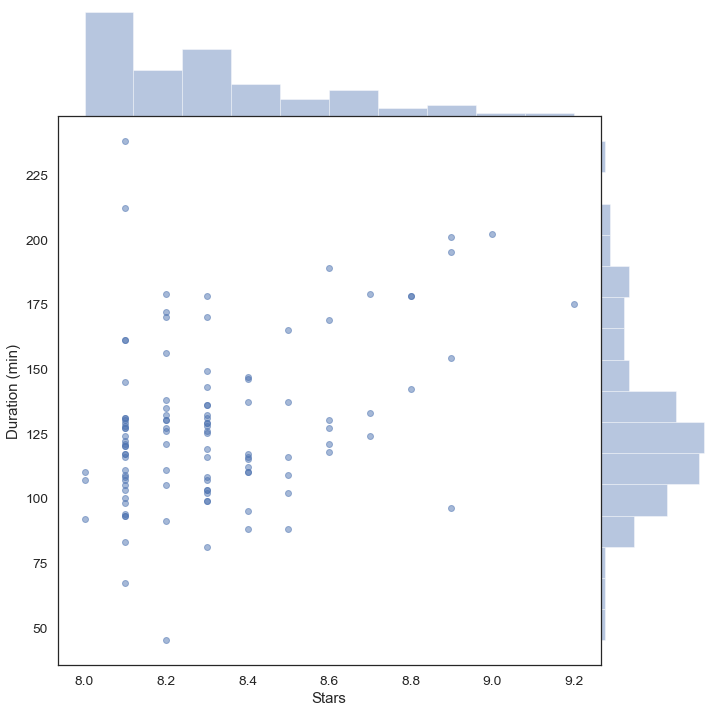

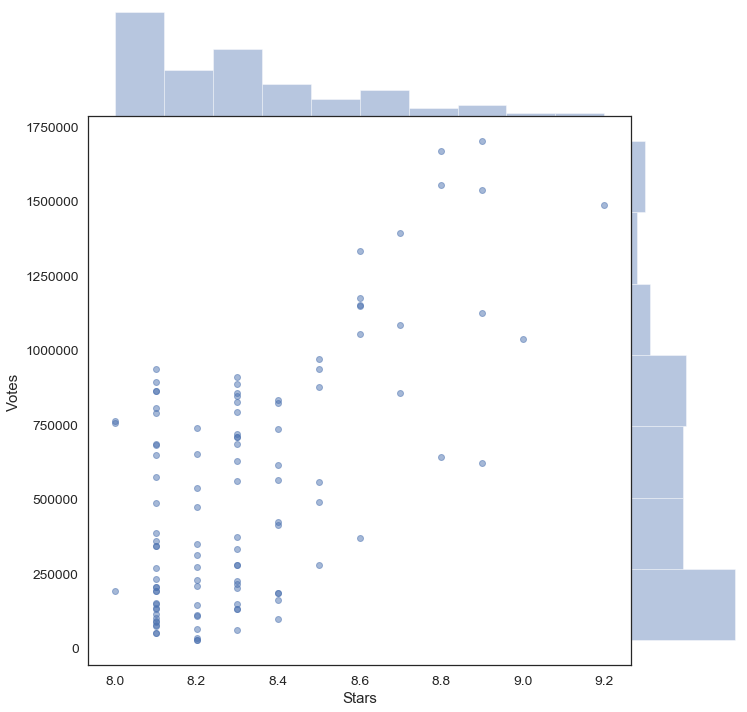

In [94]:
ratings_comparisons = ['Gross ($M)', 'Metascore', 'Duration (min)', 'Votes']

for comparison in ratings_comparisons:
    sns.jointplot(x='Stars', y=comparison, data=final_movies, alpha=0.5, color='b', size=10, space=0)

In [95]:
genre_pcts = final_movies['Genre 1'].value_counts().sort_index()
genre_i = list(genre_pcts.index)
genre_p = list(genre_pcts.values / final_movies.shape[0])

frames = [genre_i, genre_p]
genre_pcts_df = pd.DataFrame(frames)
genre_pcts_df = genre_pcts_df.T
genre_pcts_df = genre_pcts_df.rename(columns={0:'Genres', 1:'Percent'})

genre_pcts_df = genre_pcts_df.set_index('Genres')

In [96]:
genre_pcts_df

,Percent
Genres,
Action,0.127273
Adventure,0.127273
Animation,0.0454545
Biography,0.0454545
Comedy,0.1
Crime,0.172727
Drama,0.3
Film-Noir,0.00909091
Horror,0.0272727


In [97]:
genre_pcts_df['Percent'] = genre_pcts_df['Percent'].astype(float)

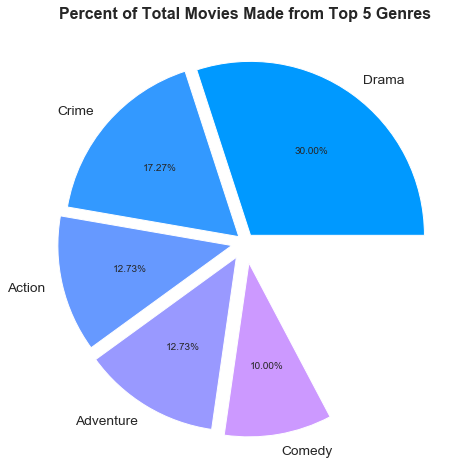

In [98]:
explode = (0.05, 0.05, 0.08, 0.1, 0.12)
colors = ['#0099FF', '#3399FF', '#6699FF', '#9999FF', '#CC99FF', ]
genre_pcts_df.sort_values(by='Percent', ascending=False).head(5).plot.pie(legend=False, subplots=True, autopct='%.2f%%', figsize=(8,8), colors=colors, explode=explode)
plt.ylabel('')
plt.title('Percent of Total Movies Made from Top 5 Genres', weight='bold', fontsize=16);


In [99]:
rev_pcts = final_movies[['Genre 1', 'Gross ($M)']]
rev_pcts = rev_pcts.groupby(['Genre 1']).sum()
total_gross = sum(list(rev_pcts['Gross ($M)']))
rev_pcts['Gross ($M)'] = rev_pcts['Gross ($M)']/total_gross


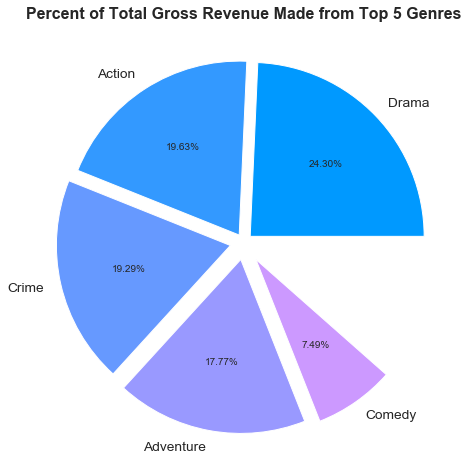

In [100]:
explode = (0.05, 0.05, 0.08, 0.1, 0.12)
colors = ['#0099FF', '#3399FF', '#6699FF', '#9999FF', '#CC99FF', ]
rev_pcts.sort_values(by='Gross ($M)', ascending=False).head(5).plot.pie(legend=False, subplots=True, autopct='%.2f%%', figsize=(8,8), colors=colors, explode=explode)
plt.ylabel('')
plt.title('Percent of Total Gross Revenue Made from Top 5 Genres', weight='bold', fontsize=16);

In [101]:
director_pcts = final_movies[['Director', 'Gross ($M)', ]]

director_pcts = director_pcts.groupby(['Director']).sum()
total_gross = sum(list(director_pcts['Gross ($M)']))
director_pcts['Gross ($M)'] = director_pcts['Gross ($M)']/total_gross
director_pcts.sort_values(by='Gross ($M)', ascending=False).head(10)

,Gross ($M)
Director,
Peter Jackson,0.106531
Jonathan Demme,0.088271
Billy Wilder,0.086869
Steven Spielberg,0.070231
George Lucas,0.069807
David Lean,0.040863
Andrew Stanton,0.039164
Frank Capra,0.035118
Carol Reed,0.034263


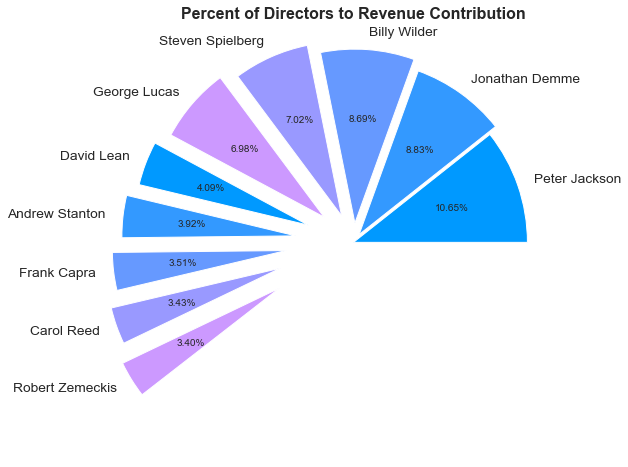

In [120]:
explode = np.linspace(0, 0.5, 10)
colors = ['#0099FF', '#3399FF', '#6699FF', '#9999FF', '#CC99FF', ]
director_pcts.sort_values(by='Gross ($M)', ascending=False).head(10).plot.pie(legend=False, subplots=True, autopct='%.2f%%', figsize=(8,8), colors=colors, explode = explode)
plt.ylabel('')
plt.title('Percent of Directors to Revenue Contribution', weight='bold', fontsize=16);

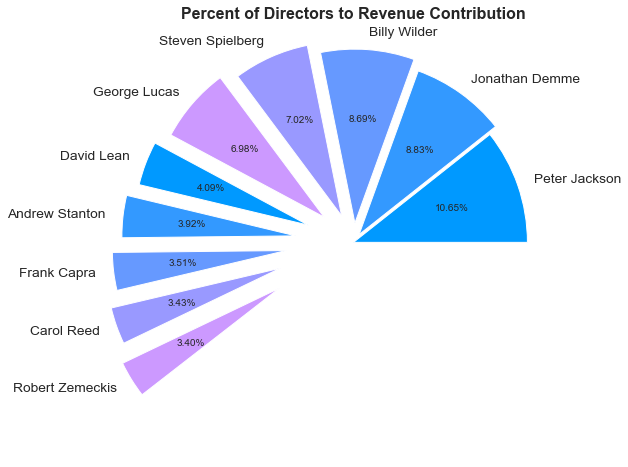

In [122]:
explode = np.linspace(0, 0.5, 10)
colors = ['#0099FF', '#3399FF', '#6699FF', '#9999FF', '#CC99FF', ]
director_pcts.sort_values(by='Gross ($M)', ascending=False).head(10).plot.pie(legend=False, subplots=True, autopct='%.2f%%', figsize=(8,8), colors=colors, explode = explode)
plt.ylabel('')
plt.title('Percent of Directors to Revenue Contribution', weight='bold', fontsize=16);

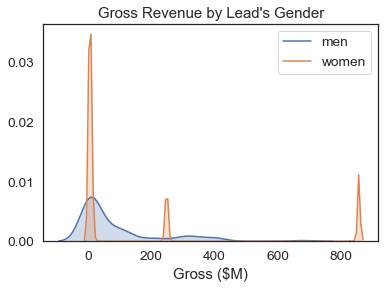

In [119]:
sns.kdeplot(final_movies['Gross ($M)'][final_movies.Gender=='M'], label='men', shade=True)
sns.kdeplot(final_movies['Gross ($M)'][final_movies.Gender=='F'], label='women', shade=True)
plt.xlabel('Gross ($M)');
plt.title("Gross Revenue by Lead's Gender");

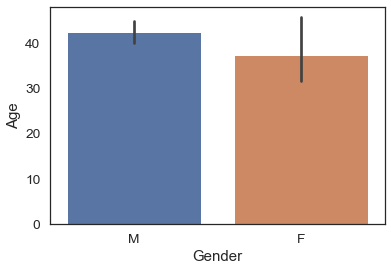

In [105]:
sns.barplot(x='Gender', y='Age', data=final_movies)

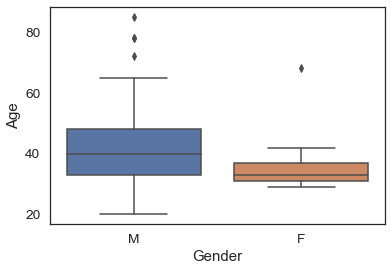

In [107]:
sns.boxplot(x='Gender', y='Age', data=final_movies)

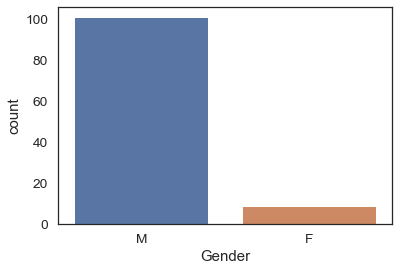

In [109]:
sns.countplot(x='Gender', data=final_movies)

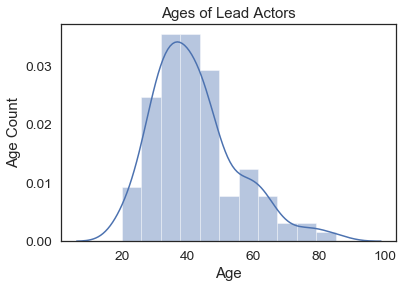

In [111]:
new = sns.distplot(final_movies.Age)
new.set_xlabel('Age')
new.set_ylabel('Age Count')
new.set_title('Ages of Lead Actors');

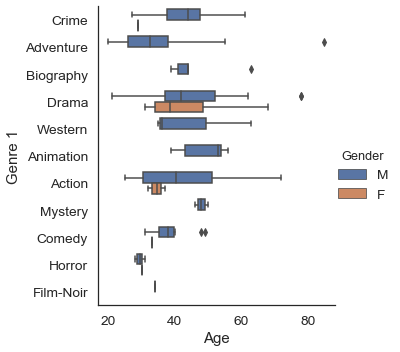

In [112]:
new = sns.catplot(x="Age",y="Genre 1",kind='box',hue='Gender',data=final_movies);


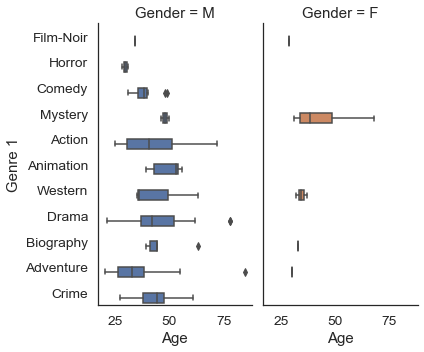

In [113]:
sns.catplot(x="Age",y="Genre 1", hue="Gender",
            col="Gender", aspect=.6,
            kind="box", data=final_movies);

In [116]:
len(final_movies[final_movies['Gender']=='F'])

9

### Results

For the duration of the project, we used Jupyter Notebook to write code in Python, and collaborated on our notebooks through git. Our repo can be found here: https://github.com/akuz91/DS-GA-1007-Project. 
 
Web scraping was utilized to extract the top 250 movie information from the IMDb website as there was no direct way to download it [1]. We used Python’s BeautifulSoup module, which is a package for parsing HTML documents [2]. We began by importing necessary packages, including the urlib.request module to open the URLs. Since the web pages were in HTML, we learned the structure by right-clicking on the page and selecting “Inspect”. By hovering over the different HTML tags, we were able to determine which features the HTML tags were referencing and subsequently identified these while writing the code to web scrape [3]. Using the soup.find_all function from BeautifulSoup, features extracted included movie title, year, rating, duration, genres, stars, Metascore, votes, revenue, director, and lead actor. Each feature was extracted in separate lists and then converted to a single data frame for manipulation. HTML tags represented single lines on the web page which were repeated in a similar fashion for each movie. For example, by referencing the HTML tag ‘h3’,{‘class’: ‘lister-item-header’}, the movie title and year for each movie on the page were extracted by using a for-loop to find all applicable items depending on their location within the line of text. 
 
Several issues came up during the extraction process, where some features required conversion to a format that could be utilized in our analysis. For example, the duration feature was extracted as a string containing the length of the movie and the word “min”. We converted the string to an integer and stripped “min” from the variable. Additionally, when the movie years were extracted, the output was a numbered list with each year enclosed by parentheses. To produce a clean list, Pandas replace functions were utilized to grab important year information. Some movies listed multiple genres (up to three), which we split on and created new columns to represent individual genres. Similarly, some instances had part of their title included in the Year column and were removed with Pandas replace method. Metascore was also difficult to extract as the output list contained multiple parentheses and line breaks between each element. Upon inspection, a pattern was discovered, and a sequence of stripping functions were applied to each element within the list. 
 
As only 50 movies appeared on each webpage, the best way to extract all 250 movies was to click through each page and scrape the current page. To do this seamlessly we used Selenium, an automated testing suite for web applications. Our code opens the browser to the first page of the IMDB list, scrapes the data of the current page, finds and clicks the “next” page and continues this cycle until the last page. Within the code is a function that scrapes the current driver page source to a data frame, resulting in a master data frame with information from each page. An important design decision in the scraping function was to incorporate code that handles movies that do not contain a rating, offsetting data for the remaining features of the movie instance. This design decision improved continuity and decreased the need for data cleaning. 
 
To complete the dataset, the web scraped data from IMDb was merged with an actor information dataset [4]. This dataset included biographical information such as actor name, gender, date of birth, and role type. Some instances within the dataset were missing birth years, so we manually checked Wikipedia for these missing values. The birth year column was also used to create a new column representing the actor’s age at the time the movie was released.


### Discussion
Binning by decade, we can see the best movies were made in the 1950s and 1990s as shown in the bar chart above. Between the two decades, we saw 40 of the best movies as provided by this dataset that make up 16% of our data. The scatter plot with appended histograms show the correlation between the number of stars a movie has and how long the movie is. There is a positive correlation between the two features, although one must keep in mind our dataset is biased to include only the best movies. In reality, we hypothesize the opposite correlation is true and these movies would be considered outliers within the total population of movies. The histograms also show us that the distribution of movie duration is almost normal with a left skewed tail, and the majority of the movies have 8 stars. 

Next, we wanted to better understand the factions of our data. This is best done by pie charts shown above. The "Percent of Total Movies Made from Top 5 Genres" pie chart shows drama, crime, and action movies are the most popular genres in our dataset, however it is adventure movies that competes with crime movies to produce the highest grossing genres as shown in the "Percent of Total Gross Revenue Made from Top 5 Genres" pie chart. The "Percent of Directors to Revenue Contribution" pie chart presents the 10 directors that contributed the most to total gross revenue. On the list is Peter Jackson who directs the Lord of the Rings movies, Jonathan Demme who directed The Silence of the Lambs and Billy Wilder, the director of Witness for the Prosecution and Sunset Blvd. Jackson’s gross for three movies compares to one of Demme’s and two of Wilder’s.

Lastly, we were interested in how gender and age played a role in our dataset. While female leads bring in more money, there are less female leads than male leads as shown by the width of distributions in the "Gross Revenue by Lead's Gender" density plot. In fact, our whole dataset only saw nine female leads. The "Ages of Lead Actors" histogram shows the distribution of the ages of leads in our dataset which is roughly normal with a right tail. The oldest lead actor was William Holden in The Bridge on the River Kwai at 85 years old, and the youngest actor in our dataset was Elijah Wood in Lord of the Rings at 20 years old. Finally, interesting results were produced when we compared age and gender with genre in our dataset. Females were casted in lead roles for four dramas, two action movies, and one comedy, crime and horror movie. Additionally, from the age distribution, it was concluded that females were much younger than the men casted for the same genre, as shown by the empirical median of our box plots. The mean age of women in our dataset is 37 while the mean age of men is 42. 

While web scraping is a useful tool and is used by many companies to drive business decisions, it is not reproducible. The code we wrote to scrape data is only applicable to the specific IMDb list and webpages for that list. As discussed in Section 2, web scraping produced some errors such as random characters in the year column, which was addressed with manual treatment and automation with Selenium. Although this is not favorable in best practice, for our purposes it helped us detect and mitigate issues. It is not recommended that the web scraping tools used be applied to larger datasets where it is likely that more errors will occur with the mapping process. It is recommended to use portions of the project that can apply to other websites such as the method used to loop through the web pages. 

### Conclusion
Using Python’s BeautifulSoup module and the automation of Selenium Python, we were able to analyze the Top 250 Movie list as presented by IMDb.com in conjunction with a database of actors’ data. Conclusions drawn from this process are that movie genres that perform well in the box office include drama, crime and action movies, however adventure movies contribute largely to total gross revenue percent. Additionally, women are historically not cast in lead roles, and when they are, their ages are, on average, less than that of men in the same genre. Our analysis can be used by movie goers and aspiring directors alike to see what elements make up the most highly rated movies of the century. 